Final Project : EC2402

Himanshu Patel 2511893

"How does female labour force participation affect GDP per capita across countries, and does this relationship vary by region?"

Link to my presentation: https://youtu.be/F-iG-yxVvVw

In [ ]:
#Libraries I've used
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from linearmodels.panel import PanelOLS, RandomEffects, PooledOLS
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Had to install linearmodels in order to do OLS regressions
!pip install linearmodels

You will have to upload the 2 csv files attached to the folder named female_lfp.csv and gdp_per_capita.csv

In [7]:
lfp_df = pd.read_csv("female_lfp.csv", skiprows=4)
lfp_df = lfp_df.drop(columns=["Indicator Name", "Indicator Code", "Unnamed: 69"])
lfp_long = lfp_df.melt(
    id_vars=["Country Name", "Country Code"],
    var_name="Year",
    value_name="Female_LFP"
)
lfp_long["Year"] = lfp_long["Year"].astype(int)
lfp_long["Female_LFP"] = pd.to_numeric(lfp_long["Female_LFP"], errors="coerce")
lfp_long = lfp_long.dropna(subset=["Female_LFP"])
lfp_long

,Country Name,Country Code,Year,Female_LFP
7981,Africa Eastern and Southern,AFE,1990,65.537699
7982,Afghanistan,AFG,1990,15.789000
7983,Africa Western and Central,AFW,1990,69.940137
7984,Angola,AGO,1990,75.607000
7985,Albania,ALB,1990,50.846000
...,...,...,...,...
17284,Samoa,WSM,2024,30.567000
17286,"Yemen, Rep.",YEM,2024,4.907000
17287,South Africa,ZAF,2024,52.992000
17288,Zambia,ZMB,2024,53.852000


First, we loaded in the data and skipped the first 4 metadata rows. Then, we dropped the columns we didn't need and the ones we can't use in the analysis. The columns we kept were: Country Name, Country Code, Year and Female LFP. Then we reshaped the data from wide to long format. Converted year to integer and LFP to numeric. Then at last, we dropped all the missing values to clean up the data.

In [10]:
gdp_df = pd.read_csv("gdp_per_capita.csv", skiprows=4)
gdp_df = gdp_df.drop(columns=["Indicator Name", "Indicator Code", "Unnamed: 69"])
gdp_long = gdp_df.melt(
    id_vars=["Country Name", "Country Code"],
    var_name="Year",
    value_name="GDP_per_capita"
)
gdp_long["Year"] = gdp_long["Year"].astype(int)
gdp_long["GDP_per_capita"] = pd.to_numeric(gdp_long["GDP_per_capita"], errors="coerce")
gdp_long = gdp_long.dropna(subset=["GDP_per_capita"])
gdp_long

,Country Name,Country Code,Year,GDP_per_capita
1,Africa Eastern and Southern,AFE,1960,186.132432
3,Africa Western and Central,AFW,1960,121.938353
13,Australia,AUS,1960,1810.706430
14,Austria,AUT,1960,939.914815
16,Burundi,BDI,1960,70.905100
...,...,...,...,...
17019,Kosovo,XKX,2023,5960.158205
17020,"Yemen, Rep.",YEM,2023,477.409029
17021,South Africa,ZAF,2023,6022.542542
17022,Zambia,ZMB,2023,1330.727806


Here we done the same as before first, we loaded in the data and skipped the first 4 metadata rows. Then, we dropped the columns we didn't need and the ones we can't use in the analysis. The columns we kept were: Country Name, Country Code, Year and GDP per capita. Then we reshaped the data from wide to long format. Converted year to integer and GDP to numeric. Then at last, we dropped all the missing values to clean up the data.

In [11]:
merged_df = pd.merge(lfp_long, gdp_long, on=["Country Code", "Year"])
merged_df = merged_df.drop(columns=["Country Name_y"])
merged_df = merged_df.rename(columns={"Country Name_x": "Country Name"})
merged_df

,Country Name,Country Code,Year,Female_LFP,GDP_per_capita
0,Africa Eastern and Southern,AFE,1990,65.537699,822.817638
1,Africa Western and Central,AFW,1990,69.940137,590.321438
2,Angola,AGO,1990,75.607000,965.866840
3,Albania,ALB,1990,50.846000,617.230436
4,Arab World,ARB,1990,19.362995,2875.257142
...,...,...,...,...,...
7814,Samoa,WSM,2023,31.055000,4330.178405
7815,"Yemen, Rep.",YEM,2023,4.939000,477.409029
7816,South Africa,ZAF,2023,52.929000,6022.542542
7817,Zambia,ZMB,2023,53.931000,1330.727806


First, we merged the two datasets by the common variables; Country Code and Year. Then we dropped the extra column, Country Name_y, which came up due to country name being duplicated. Then we renamed Country Name_x to just Country Name.

In [12]:
aggregate_regions = [
    "Arab World", "East Asia & Pacific", "Europe & Central Asia", "Latin America & Caribbean",
    "Middle East & North Africa", "North America", "South Asia", "Sub-Saharan Africa",
    "World", "OECD members", "Low income", "High income", "Upper middle income", "Lower middle income"
]

merged_df["Region_Type"] = merged_df["Country Name"].apply(lambda x: "Region" if x in aggregate_regions else "Country")
merged_df

,Country Name,Country Code,Year,Female_LFP,GDP_per_capita,Region_Type
0,Africa Eastern and Southern,AFE,1990,65.537699,822.817638,Country
1,Africa Western and Central,AFW,1990,69.940137,590.321438,Country
2,Angola,AGO,1990,75.607000,965.866840,Country
3,Albania,ALB,1990,50.846000,617.230436,Country
4,Arab World,ARB,1990,19.362995,2875.257142,Region
...,...,...,...,...,...,...
7814,Samoa,WSM,2023,31.055000,4330.178405,Country
7815,"Yemen, Rep.",YEM,2023,4.939000,477.409029,Country
7816,South Africa,ZAF,2023,52.929000,6022.542542,Country
7817,Zambia,ZMB,2023,53.931000,1330.727806,Country


Here, we added a column to distinguish between aggregate regions and individual countries. We then wrote each region individually to make sure we don't miss any. Then at last, we created a new column which will tell us whether the row is an aggregate region or an individual country.

In [57]:
country_df = merged_df[~merged_df["Country Name"].isin(aggregate_regions)].copy()

region_df = merged_df[merged_df["Country Name"].isin(aggregate_regions)].copy()

Here, we split the data to give us 2 dataframes, the country dataframe to use for our main regression. And the region dataframe to use for our regional analysis, for comparing regional patterns.

First model we use is an OLS model, and the purpose of this model is to establish the baseline understanding of the relationship between the female LFP and GDP per capita using a simple linear regression. The OLS estimates the average effect across all observations, it helps us visualise and interpret the general relationship between female LFP and GDP per capita, but without considering time or country-specific effects. Which we will consider in our later models.

In [18]:
X = sm.add_constant(country_df['Female_LFP'])
y = country_df['GDP_per_capita']
ols_model = sm.OLS(y, X).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:         GDP_per_capita   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     63.69
Date:                Fri, 16 May 2025   Prob (F-statistic):           1.68e-15
Time:                        00:32:48   Log-Likelihood:                -81607.
No. Observations:                7343   AIC:                         1.632e+05
Df Residuals:                    7341   BIC:                         1.632e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5430.1824    643.125      8.443      0.0

Here are what the results mean; the intercept (const) which was 5430.1824, means that when female LFP is 0 the GDP per capita is predicted to be $$5430. The female_LFP coefficient means that for every 1 percentage point increase in female labour participation, GDP per capita increases by $98.36 on average. And because the p value is very small, this means the effect is statistically significant. However, the R^2 is only 0.009, which means only 0.9% of the GDP per capita variation is explained by female LFP. This could be because the model has quite a lot of limitations such as not controlling for time or country-specific factors

The OLS regression suggests that female labour force participation has a statiscally significant but economocially small association with GDP per capita. Due, to the model explaining less than 1% of the variation in GDP, and does not control for time or country-specific factors. This means we need to use another model to further analyse this.

Second model we are using is the Pooled OLS model, and the purpose of this model is to extend the OLS to a panel  structure by pooling all observations across time and countries. It allows for using all data points in a single regression, it's also useful for comparing results with more complex models like the fixed effects which we will get onto after this. And it assumes all countries behave the same, which is not realistic but it helps us to compare.

In [19]:
panel_data = country_df.set_index(['Country Code', 'Year'])
exog = sm.add_constant(panel_data['Female_LFP'])
pooled_model = PooledOLS(panel_data['GDP_per_capita'], exog).fit()
print(pooled_model.summary)

                          PooledOLS Estimation Summary                          
Dep. Variable:         GDP_per_capita   R-squared:                        0.0086
Estimator:                  PooledOLS   R-squared (Between):              0.0028
No. Observations:                7343   R-squared (Within):               0.0337
Date:                Fri, May 16 2025   R-squared (Overall):              0.0086
Time:                        00:33:22   Log-likelihood                -8.161e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      63.686
Entities:                         220   P-value                           0.0000
Avg Obs:                       33.377   Distribution:                  F(1,7341)
Min Obs:                       8.0000                                           
Max Obs:                       34.000   F-statistic (robust):             63.686
                            

Here are what the results mean, the intercept is the same as the basic OLS, which means the GDP per capita is $$5430.2 when female LFP is 0. The female_LFP coefficient is 98.362 which means that a 1% increase in female labour force participation leads to a $98.36 increase in GDP per capita, just like in the basic OLS. And the p value being 0 means this is also statistically significant and the R^2 being 0.0086 means it is also explains only 0.86% variation of GDP per capita.

The Pooled OLS model treats all observations as independent, ignoring unobserved heterogeneity across countries and over time. Although female labor force participation is statistically significant, it also fails to capture much of the variation of GDP per capita. This means we have to use fixed effects to fully analyse this.

Third and last model we're using is fixed effects model, the purpose of this model is to control for unobserved characteristics that are constant over time within each country such as long-standing policies or cultural norms etc. It focuses on within-country variation, it also removes country-specific bias that can distort the true effect of female lFP. This means this model is most likely the most relevant for this study.

In [92]:
panel_data = country_df.set_index(['Country Code', 'Year'])
exog = sm.add_constant(panel_data['Female_LFP'])
fe_model = PanelOLS(panel_data['GDP_per_capita'], exog, entity_effects=True).fit()
print(fe_model.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:         GDP_per_capita   R-squared:                        0.1308
Estimator:                   PanelOLS   R-squared (Between):             -0.4262
No. Observations:                7343   R-squared (Within):               0.1308
Date:                Fri, May 16 2025   R-squared (Overall):             -0.3235
Time:                        04:48:08   Log-likelihood                -7.486e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      1071.7
Entities:                         220   P-value                           0.0000
Avg Obs:                       33.377   Distribution:                  F(1,7122)
Min Obs:                       8.0000                                           
Max Obs:                       34.000   F-statistic (robust):             1071.7
                            

Here are what the results mean, the intercept has no meaningful standalone interpretation because that is the base value after accounting for each country's fixed effect, hence it's a residual baseline and has no practical standalone meaning. However on the other hand, the female_LFP coefficient being 709.62 means that for a 1% increase in female labour force participation within a country is associated with a $709.62 increase in the GDP per capita. And the p value being 0 means this is statistically significant. The R^2 value being 0.1308 means that 13.08% of the variation in GDP per capita is explained by female LFP, which is much better than the OLS and Pooled model. Also, the F test where p < 0.0001, shows strong evidence against pooling, meaning fixed effects is preferred over Pooled OLS.

I used the Fixed Effects model to control for unobserved, time-invariant heterogenity across countries. This is crucial because factors like culture and geography may influence both GDP and female labour force participation and ignoring them would lead to omitted variable bias. The model shows that within a country, a 1% increase in female labor force participation is associated with a $709.62 increase in GDP per capita. This relationship is statistically significant, and the R^2 of 13.08% suggests a meaningful explanatory power. The F-test for poolability confirms that fixed effects are preferable to a pooled model.

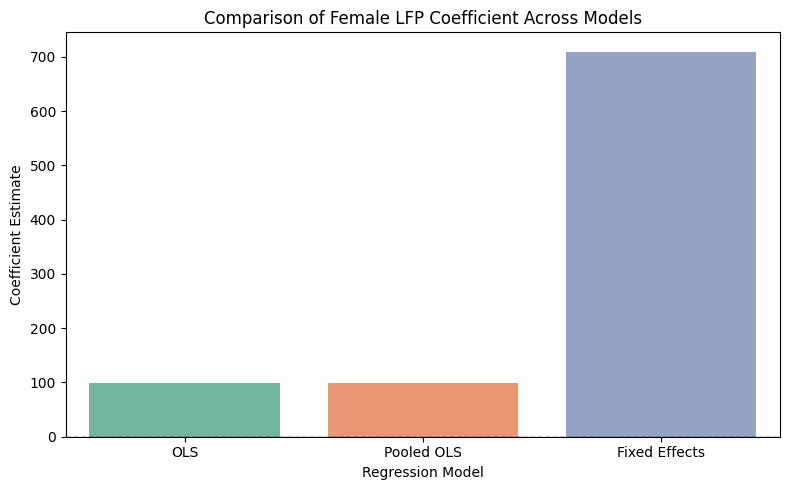

In [93]:
data = {
    'Model': ['OLS', 'Pooled OLS', 'Fixed Effects'],
    'Coefficient': [
        ols_model.params['Female_LFP'],
        pooled_model.params['Female_LFP'],
        fe_model.params['Female_LFP']
    ]
}

df = pd.DataFrame(data)

plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='Coefficient', data=df, palette='Set2')
plt.title('Comparison of Female LFP Coefficient Across Models')
plt.ylabel('Coefficient Estimate')
plt.xlabel('Regression Model')
plt.axhline(0, linestyle='--', color='black', linewidth=1)
plt.tight_layout()
plt.show()


Here we compare the estimated effect of female labor force participation on GDP per capita across three different regression models. All models show a positive relationship, but the fixed effects model accounts for unobserved country-specific factors, giving us a more robust estimate.

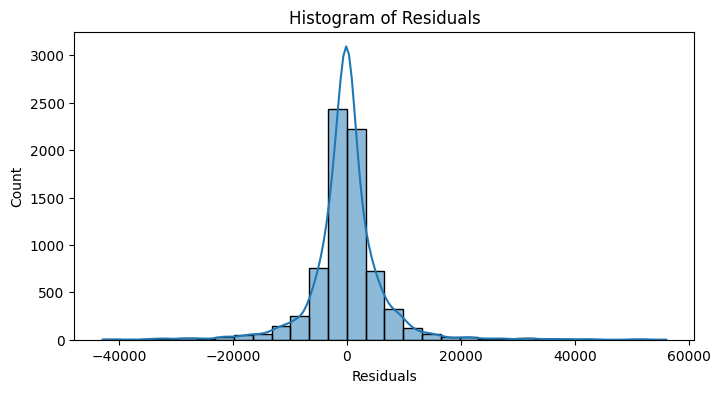

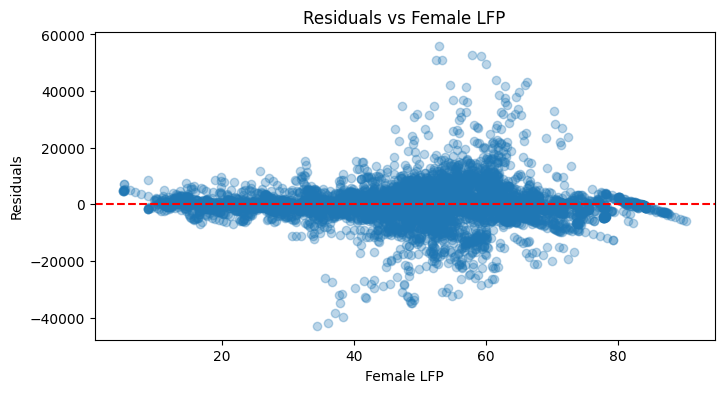

In [31]:
residuals = fe_results.resids

plt.figure(figsize=(8, 4))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.show()

plt.figure(figsize=(8, 4))
plt.scatter(country_df['Female_LFP'], residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Female LFP")
plt.xlabel("Female LFP")
plt.ylabel("Residuals")
plt.show()


To check the assumptions of our fixed effects regression model, we examined the residuals through two plots, a histogram and a residual vs. predictor scatter plot.

The histogram shows us the distribution of the residuals. In our plot, the residuals are roughly symmetric and centered around zero. Which suggests the errors are normally distributed. This supports the assumption of normality needed for valid inference in linear regression.

The scatter plot shows the residuals plotted against the indepedent variable, female LFP. The residuals appear to be randomly scattered around 0, without showing a clear pattern. However, the plot indicates the presence of several outliers which can affect the model's predictive accuracy. In order to mitigate the impact, I have decided to apply log transformations and robust standard errors which I will show next.

In [34]:
country_df['log_GDP'] = np.log(country_df['GDP_per_capita'])

panel_data = country_df.set_index(['Country Code', 'Year'])

fe_model_log = PanelOLS.from_formula('log_GDP ~ Female_LFP + EntityEffects', data=panel_data)

fe_results_log = fe_model_log.fit(cov_type='clustered', cluster_entity=True)

print(fe_results_log.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                log_GDP   R-squared:                        0.0105
Estimator:                   PanelOLS   R-squared (Between):              0.1922
No. Observations:                7343   R-squared (Within):               0.0105
Date:                Fri, May 16 2025   R-squared (Overall):              0.1912
Time:                        02:54:22   Log-likelihood                   -6576.5
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      75.750
Entities:                         220   P-value                           0.0000
Avg Obs:                       33.377   Distribution:                  F(1,7122)
Min Obs:                       8.0000                                           
Max Obs:                       34.000   F-statistic (robust):             3.4911
                            

First, we transformed the GDP into logs which improved the model assumptions and reduced the influences of outliers. Also by using robust standard errors, we addressed heteroskedasticty and serial correlation between countries, which makes inference more reliable. As for the results, the positive coefficient supports the hypothesis that higher female LFP tends to relate to higher GDP per capita. However, the low R^2 implies that many other factors affect GDP beyond female LFP which is outside of our study.

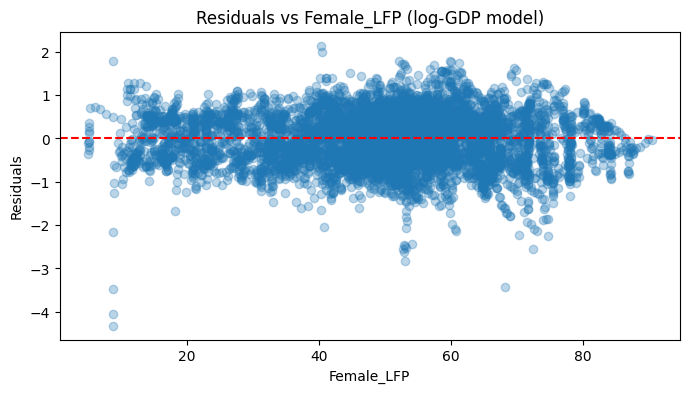

In [37]:
residuals_log = fe_results_log.resids

plt.figure(figsize=(8,4))
plt.scatter(country_df['Female_LFP'], residuals_log, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Female_LFP (log-GDP model)")
plt.xlabel("Female_LFP")
plt.ylabel("Residuals")
plt.show()


After using the log-transformed model, we can see the residual plot against female LFP shows a fairly random spread around zero. Which suggests linearity and homoskedasticity assumptions hold well. However, some outliers are still visible, which might impact the model fit. But this does justify using robust standard errors to account for potential heteroskedasticity.

In [67]:
region_panel_data = region_df.set_index(['Country Code', 'Year'])
exog = sm.add_constant(region_panel_data['Female_LFP'])
region_fe_model = PanelOLS(region_panel_data['GDP_per_capita'], exog, entity_effects=True).fit()
print(region_fe_model.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:         GDP_per_capita   R-squared:                        0.0111
Estimator:                   PanelOLS   R-squared (Between):              0.0531
No. Observations:                 476   R-squared (Within):               0.0111
Date:                Fri, May 16 2025   R-squared (Overall):              0.0465
Time:                        03:25:39   Log-likelihood                   -4802.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      5.1526
Entities:                          14   P-value                           0.0237
Avg Obs:                       34.000   Distribution:                   F(1,461)
Min Obs:                       34.000                                           
Max Obs:                       34.000   F-statistic (robust):             5.1526
                            

We estimated a region-level fixed effects model to understand how the relationship between female LFP and GDP per capita varies over time within regions, controlling for unobserved region-specific factors. The positive and statistically significant coefficient for female_LFP indicates that female LFP within regions are associated with increases in GDP per capita, holding constant region-specific characteristics. The model explains a modest share within-region GDP variation, which is typical given how complex economic growth is. Some limitations however are that the model doesn't capture all factors affecting GDP per capita, and the R^2 reflects that.

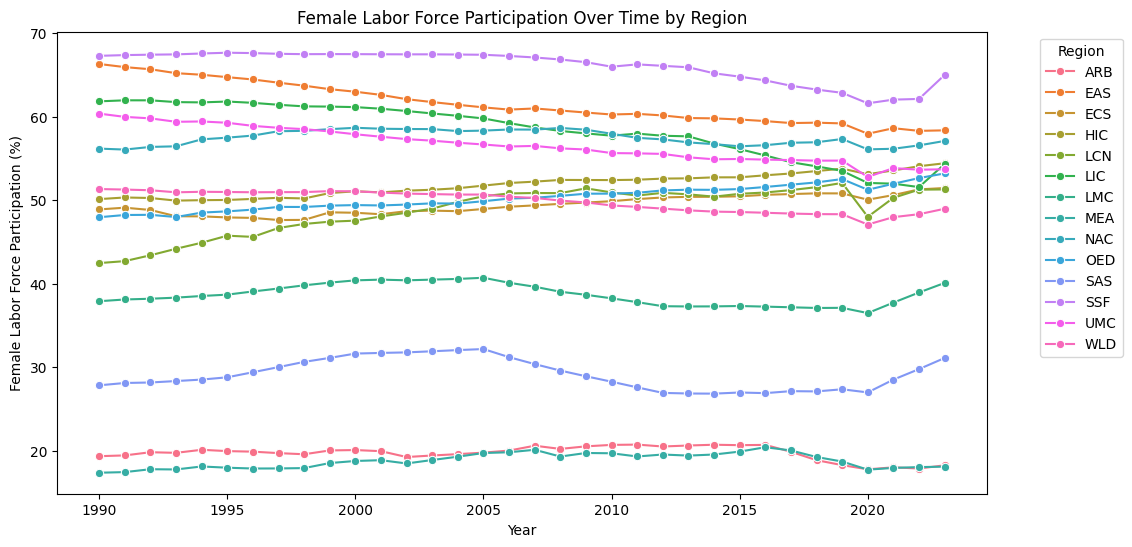

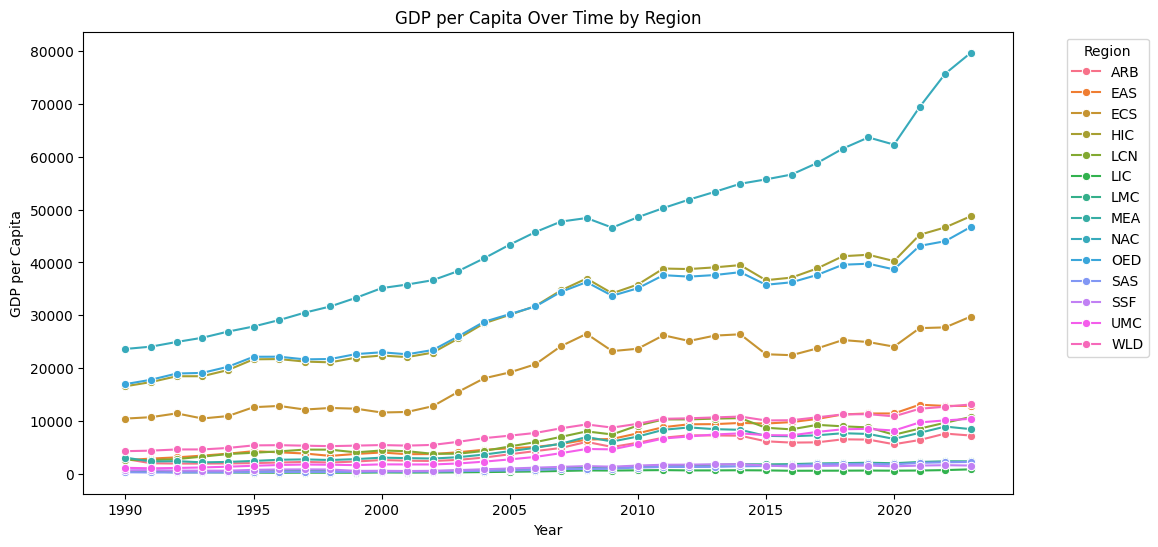

In [84]:
plt.figure(figsize=(12,6))
sns.lineplot(data=region_df, x='Year', y='Female_LFP', hue='Country Code', marker='o')
plt.title('Female Labor Force Participation Over Time by Region')
plt.ylabel('Female Labor Force Participation (%)')
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

plt.figure(figsize=(12,6))
sns.lineplot(data=region_df, x='Year', y='GDP_per_capita', hue='Country Code', marker='o')
plt.title('GDP per Capita Over Time by Region')
plt.ylabel('GDP per Capita')
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


The line plots show us the trends of GDP per capita and Female LFP from 1990 to 2024, each coloured line represents a different region, to make it easier for us to visually compare. We observe that some regions like SSF and EAS have higher and steadily increasing female labour participation, while other regions like ARB have lower participation levels. Same with GDP per capita we can see OED with high levels of GDP per capita and SSF with lower levels.

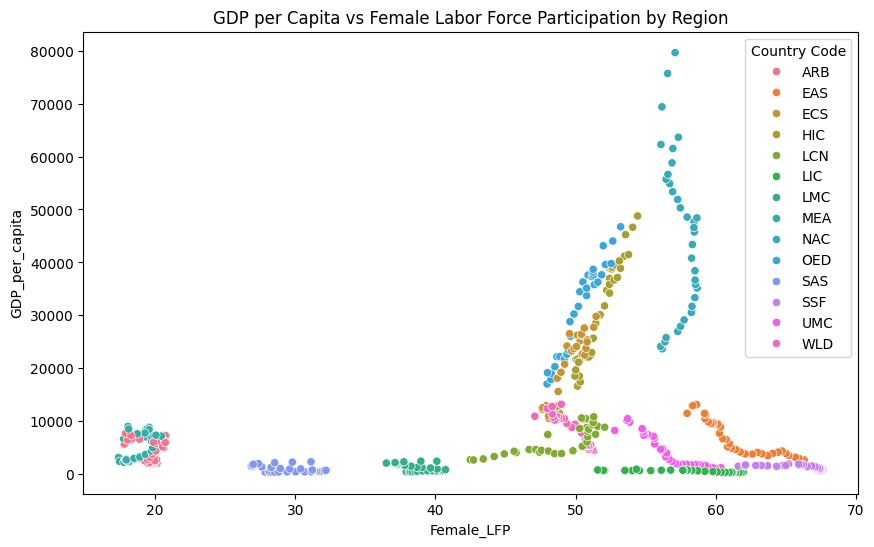

In [81]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=region_df, x='Female_LFP', y='GDP_per_capita', hue='Country Code')
plt.title('GDP per Capita vs Female Labor Force Participation by Region')
plt.show()

The scatterplot displays the relationship between Female_LFP on the x-axis and GDP per capita on the y-axis. Each point represents an observation for a region in a specific year. We observe a positive trend overall, indicating that regions with higher female labor participation generally tend to have higher GDP per capita.

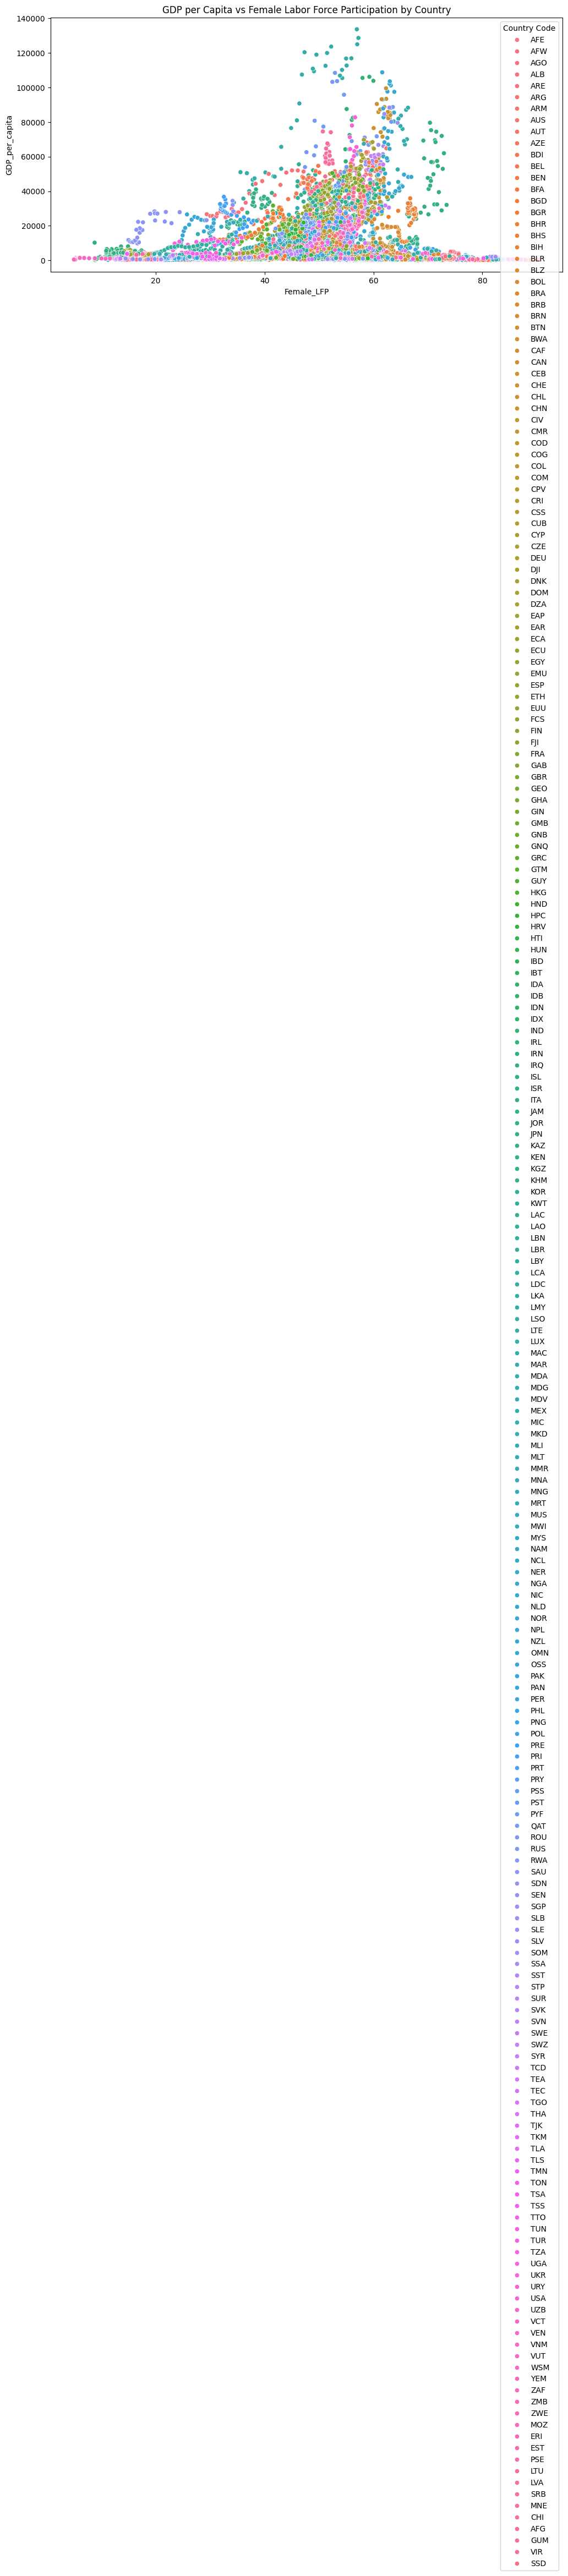

In [87]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=country_df, x='Female_LFP', y='GDP_per_capita', hue='Country Code')
plt.title('GDP per Capita vs Female Labor Force Participation by Country')
plt.show()

The scatterplot shows data points representing individual countries, plotting their average Female LFP on the x-axis against their average GDP per capita on the y-axis. Each point corresponds to a country’s overall performance across the observed years. It looks very clustered due to there being so many countries to put in. But the overall trend is shows a positive association between female labour force participation and GDP per capita across countries. However there is a noticeable variation in the spread of points, which suggests that while the trend exists, other country-specific factors likely influence GDP per capita. Some countries stand out as outliers, with high GDP per capita levels and low female LFP levels or the opposite, these are due to unique economic conditions. But the overall trend is positive, and suggests that policies that promote female labour force participation might positively impact economic growth at the country level.

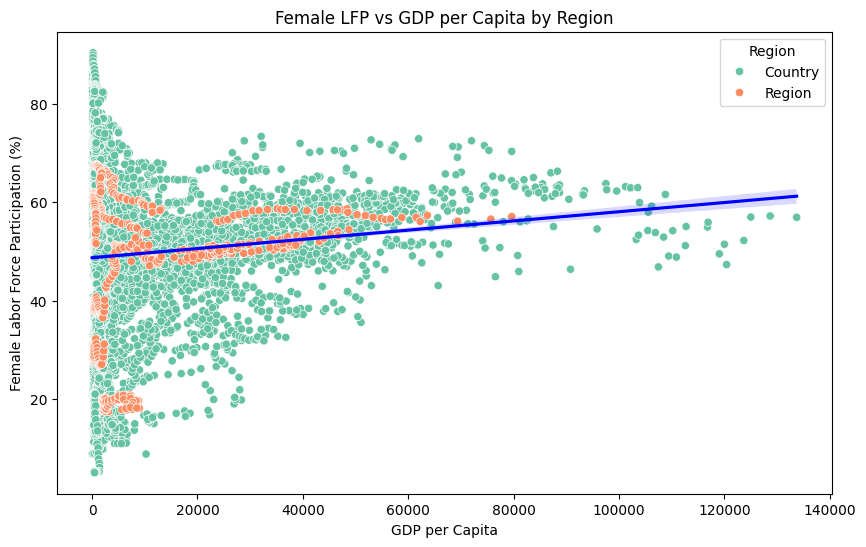

In [86]:
combined_df = pd.concat([country_df, region_df], ignore_index=True)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=combined_df, x='GDP_per_capita', y='Female_LFP', hue='Region_Type', palette='Set2')
sns.regplot(data=combined_df, x='GDP_per_capita', y='Female_LFP', scatter=False, color='blue')
plt.title("Female LFP vs GDP per Capita by Region and Country")
plt.xlabel("GDP per Capita")
plt.ylabel("Female Labor Force Participation (%)")
plt.legend(title='Region')
plt.show()

This scatterplot is combining both the region and country and showing the relationship between female LFP and GDP per capita with different geographic contexts. The regression line in blue shows a general positive trend suggesting that higher GDP per capita is associated with higher female labor force participation across the combined data. The plot highlights that while the overall trend is positive, there is considerable variability within and between regions and countries, which indicates there are more complex underlying socio-economic factors. This visualisation helps contextualise the quantitative findings we got from our panel regressions by illustrating the relationship patterns across multiple levels of aggregation.

**Conclusion**

This project has explored the relationship between female labour participation and GDP per capita across countries and regions using various panel data models. And there was consistent positive association found across ordinary least squares, pooled and fixed effects model highlights the important role that female participation in the workforce plays in driving economic growth.

Including fixed effects model allowed us to control for unobserved, time-invariant heterogenity at the country and regional levels, providing us with more robust insights. Visualisations also futher reinforced the regional and country differences in this relationship, stating that economic and social contexts matter.

While the models suggest that increasing female labor force participation is generally linked to higher GDP per capita, the variability between regions points to the importance of targeted policies that address specific local factors.

Overall, this project demonstrates the value of combining regression modelling with clear, visual analysis to better understand complex socio-economic dynamics. However, further research would be needed to fully analyse what influences the variation in GDP per capita and what other factors are involved. But for our research question we can say that a higher female labour force participation does lead to a higher GDP per capita across countries, and this relationship is more or less the same across regions.
